In [1]:
"""Data inspection."""

'Data inspection.'

In [11]:
import csv
import glob
import matplotlib
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import animation
import nibabel
import os
import sklearn
import shutil

import torch
import numpy as np
import pickle
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets

import importlib
import analyze
importlib.reload(analyze)
import datasets
importlib.reload(datasets)
import vis
importlib.reload(vis)

CRYO_DIR = '/cryo/'
TRAIN_VAL_DIR = os.path.join(CRYO_DIR, 'train_val_datasets')
OUTPUT = '/scratch/users/nmiolane/output_cryo_exp'
DEVICE = 'cuda'

IMG_SHAPE = (128, 128)
SHAPE_STR = datasets.get_shape_string(IMG_SHAPE)
TRAIN_IMG_PATH = os.path.join(TRAIN_VAL_DIR, 'cryo_exp_%s.npy' % SHAPE_STR)
TRAIN_LABELS_PATH = os.path.join(TRAIN_VAL_DIR, 'cryo_exp_labels_%s.csv' % SHAPE_STR)

Loading /cryo/train_val_datasets/cryo_exp_128x128.npy
Dataset shape: (8278, 1, 128, 128)


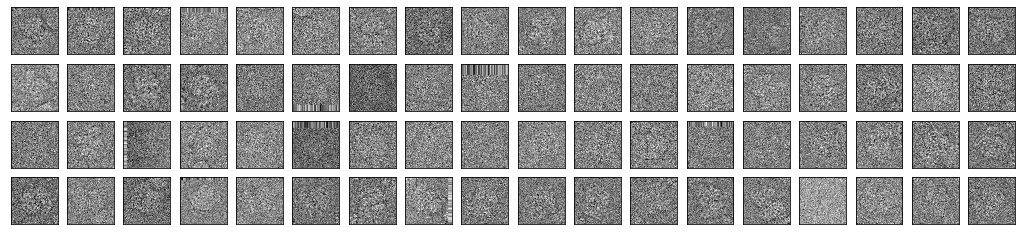

In [12]:
vis.show_data(TRAIN_IMG_PATH)

# Inspect the latent space

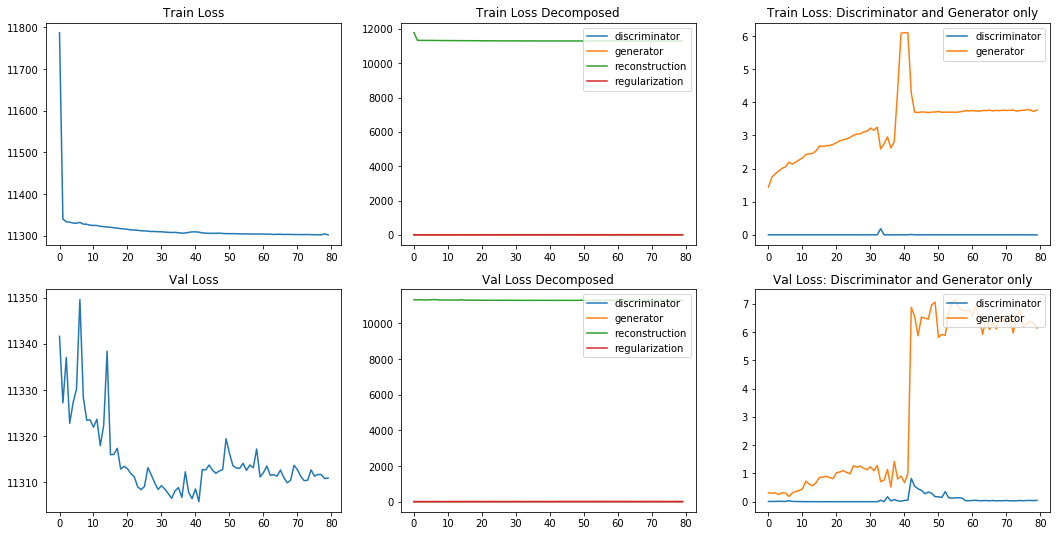

In [13]:
epoch_id = 79
vis.plot_losses(OUTPUT, epoch_id=epoch_id)

Loading: /scratch/users/nmiolane/output_cryo_exp/training/models/epoch_40_encoder_train_loss_11309.4448_val_loss_11308.4987.pth


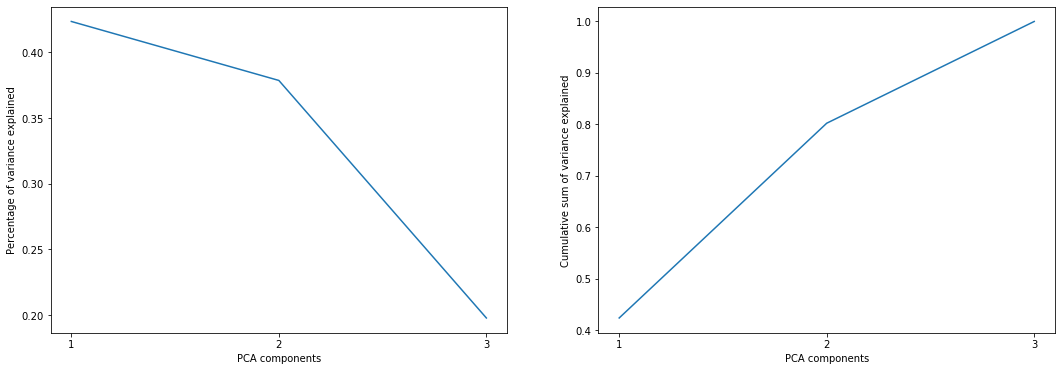

In [14]:
epoch_id = 40
ax = vis.plot_variance_explained(OUTPUT, TRAIN_IMG_PATH, epoch_id=epoch_id)

In [15]:
def get_cryo(img_path, labels_path=None, n_pc=2, epoch_id=None):
    labels = {}
    labels['focus'] = []
    labels['theta'] = []
    if labels_path is not None:
        with open(labels_path, 'r') as csv_file:
            reader = csv.reader(csv_file)
            for i_row, row in enumerate(reader):
                if i_row == 0:
                    continue
                labels['focus'].append(float(row[0]))
                labels['theta'].append(float(row[1]))
        
    test_dataset = np.load(img_path)
    # Note: the test dataset needs to be unshuffled here
    mus = analyze.latent_projection(OUTPUT, test_dataset, epoch_id=epoch_id)
    _, projected_mus = analyze.pca_projection(mus, n_pc)

    return projected_mus, labels

In [16]:
FOCUS_MAX = 3.
start = 0.5
by = 0.5
num = int((FOCUS_MAX - start) / by + 1)
colormap = cm.get_cmap('viridis')
COLORS_FOCUS = colormap(np.linspace(start=0, stop=1, num=num))

start = -180
by = 1
num = 2 * 180 + 1
colormap = cm.get_cmap('twilight')
COLORS_THETA = colormap(np.linspace(start=0, stop=1, num=num))

COLORS = {
    'focus': COLORS_FOCUS,
    'theta': COLORS_THETA
}

def plot_cryo(ax, img_path, labels_path, n_pc=2, label_name='focus', epoch_id=None):
    projected_mus, labels = get_cryo(img_path, labels_path, n_pc=n_pc, epoch_id=epoch_id)
    colored_labels = labels[label_name]
    focuses = labels['focus']

    for mu, colored_label, focus in zip(projected_mus, colored_labels, focuses):
        #if label_name == 'theta' and focus != 2.5:
        #    continue
        if label_name == 'focus':
            color_id = int(2 * colored_label) - 1
        elif label_name == 'theta':
            color_id = int((colored_label + 180))
            
        colors = COLORS[label_name]
        if n_pc == 2:
            im = ax.scatter(mu[0], mu[1], c=np.array([colors[color_id]]), s=4)
        else:
            im = ax.scatter(mu[0], mu[1], mu[2], c=np.array([colors[color_id]]))
    return im, ax

# 2D

In [17]:
projected_mus, _ = get_cryo(TRAIN_IMG_PATH, n_pc=2, epoch_id=epoch_id)

Loading: /scratch/users/nmiolane/output_cryo_exp/training/models/epoch_40_encoder_train_loss_11309.4448_val_loss_11308.4987.pth


(8278, 2)


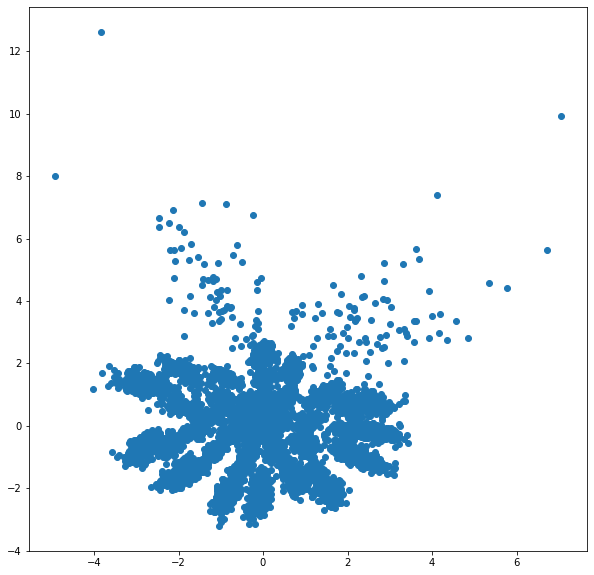

In [18]:
print(projected_mus.shape)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
im = ax.scatter(projected_mus[:, 0], projected_mus[:, 1])

In [34]:
projected_mus, _ = get_cryo(TRAIN_IMG_PATH, n_pc=2, epoch_id=79)

Loading: /scratch/users/nmiolane/output_cryo_exp/training/models/epoch_79_encoder_train_loss_11302.4647_val_loss_11310.8599.pth


(8278, 2)


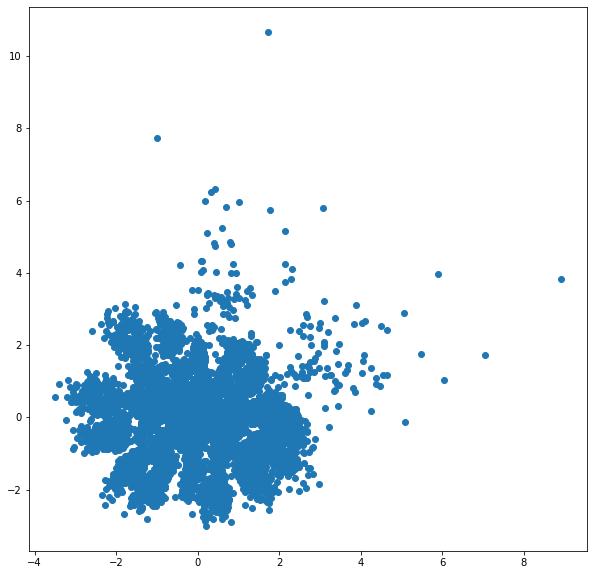

In [35]:
print(projected_mus.shape)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
im = ax.scatter(projected_mus[:, 0], projected_mus[:, 1])

# 3D

In [19]:
projected_mus, _ = get_cryo(TRAIN_IMG_PATH, n_pc=3, epoch_id=epoch_id)

Loading: /scratch/users/nmiolane/output_cryo_exp/training/models/epoch_40_encoder_train_loss_11309.4448_val_loss_11308.4987.pth


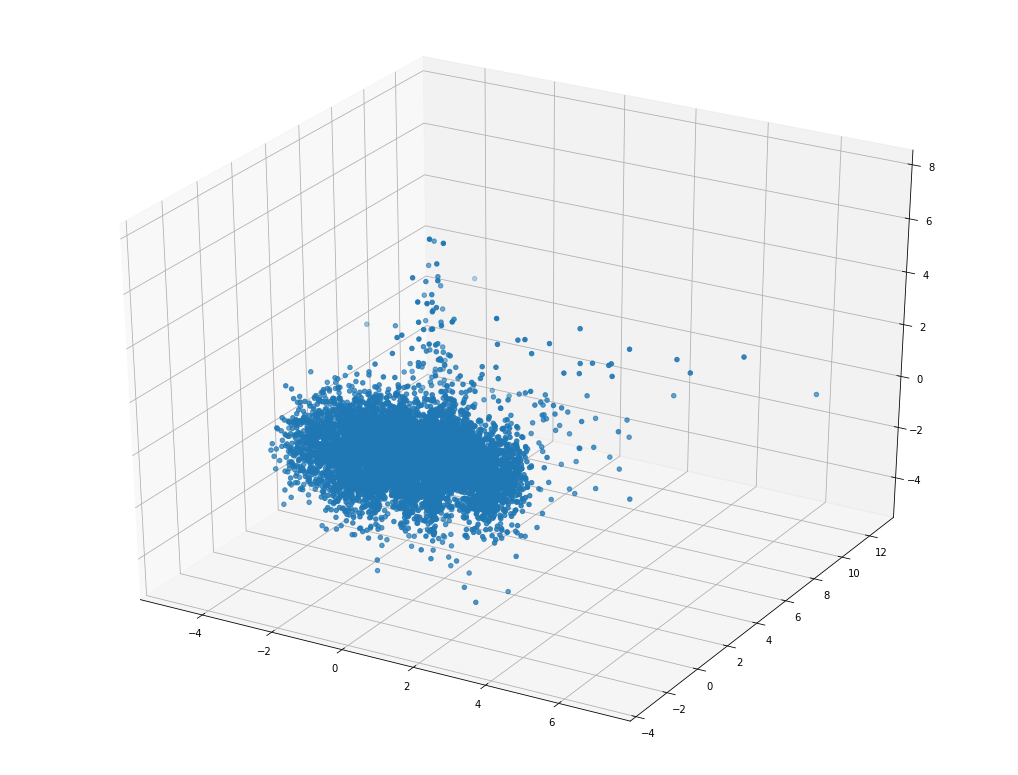

In [20]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(18, 14))
ax = fig.add_subplot(111, projection='3d')

im = ax.scatter(projected_mus[:, 0], projected_mus[:, 1], projected_mus[:, 2])

# Reconstructions

Shape of img data:
(8, 1, 128, 128)
Shape of recon:
(8, 1, 128, 128)


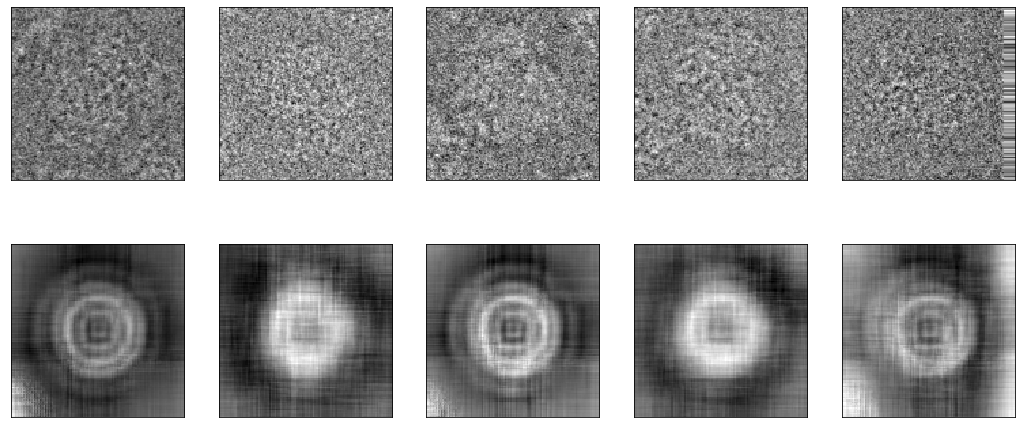

In [21]:
epoch_id = 1
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Shape of img data:
(8, 1, 128, 128)
Shape of recon:
(8, 1, 128, 128)


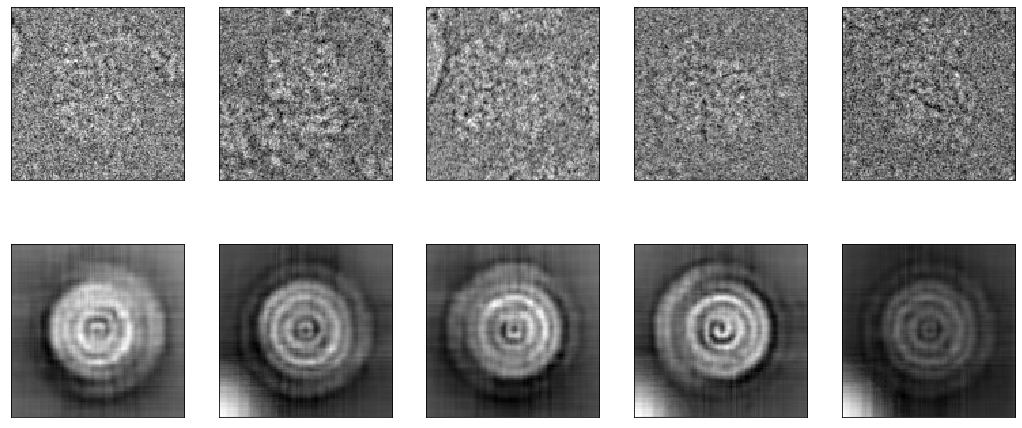

In [22]:
epoch_id = 5
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Shape of img data:
(8, 1, 128, 128)
Shape of recon:
(8, 1, 128, 128)


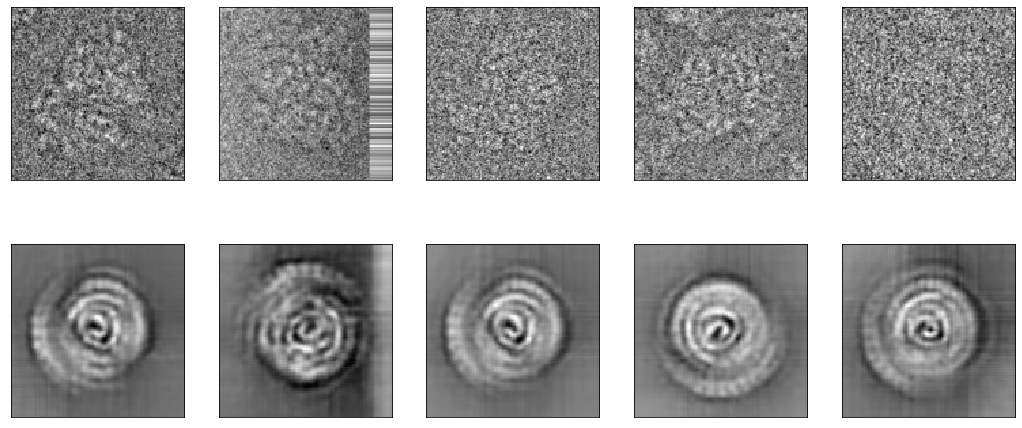

In [23]:
epoch_id = 10
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Shape of img data:
(8, 1, 128, 128)
Shape of recon:
(8, 1, 128, 128)


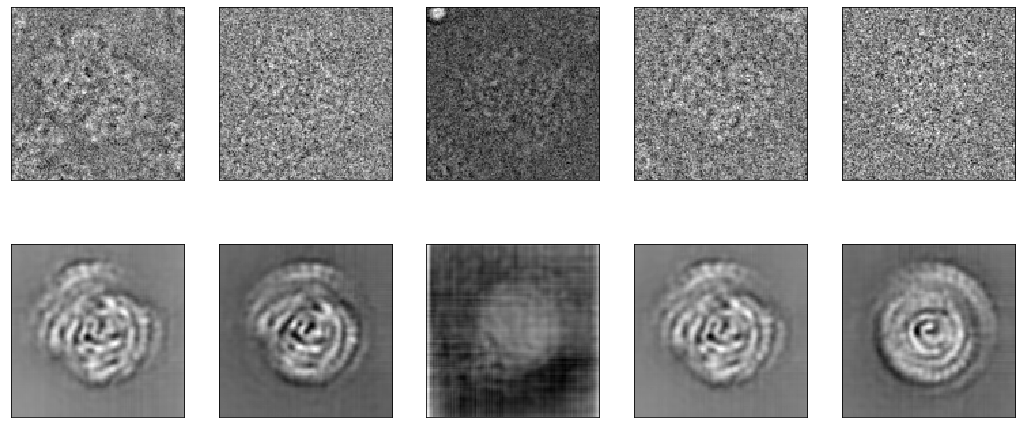

In [24]:
epoch_id = 15
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Shape of img data:
(8, 1, 128, 128)
Shape of recon:
(8, 1, 128, 128)


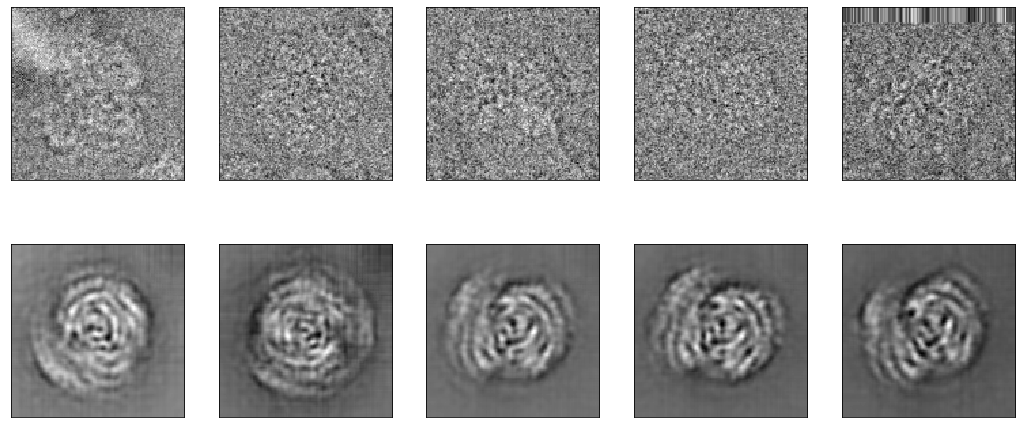

In [25]:
epoch_id = 20
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Shape of img data:
(8, 1, 128, 128)
Shape of recon:
(8, 1, 128, 128)


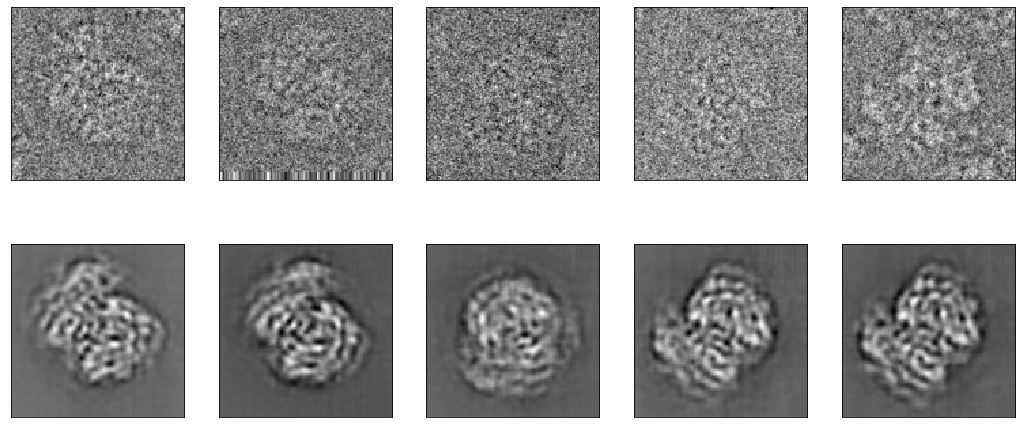

In [26]:
epoch_id = 25
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Shape of img data:
(8, 1, 128, 128)
Shape of recon:
(8, 1, 128, 128)


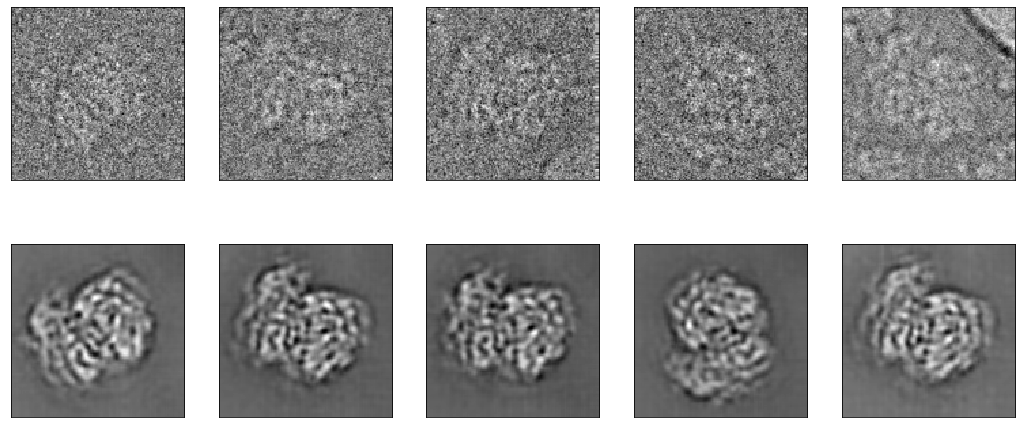

In [27]:
epoch_id = 30
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Shape of img data:
(8, 1, 128, 128)
Shape of recon:
(8, 1, 128, 128)


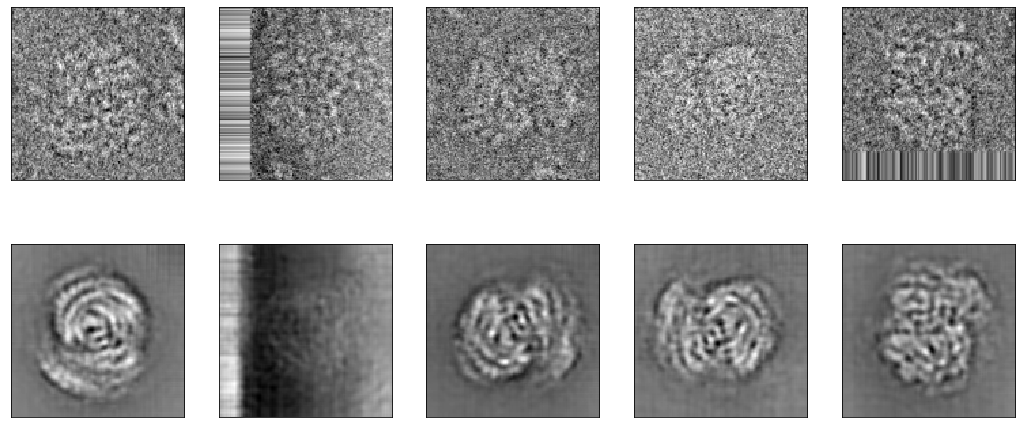

In [28]:
epoch_id = 35
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Shape of img data:
(8, 1, 128, 128)
Shape of recon:
(8, 1, 128, 128)


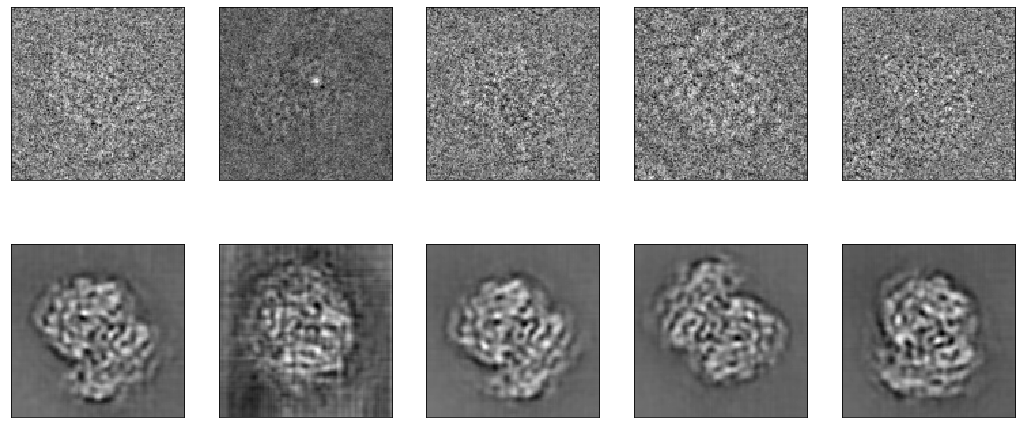

In [29]:
epoch_id = 40
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Shape of img data:
(8, 1, 128, 128)
Shape of recon:
(8, 1, 128, 128)


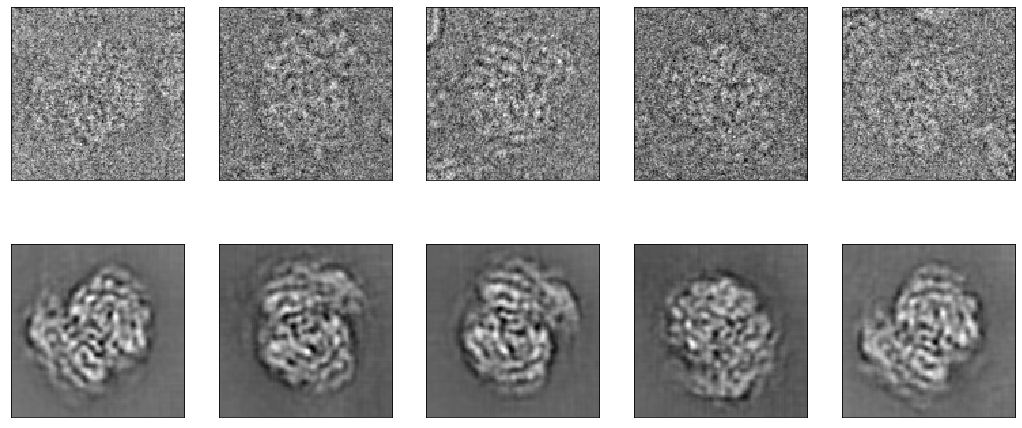

In [30]:
epoch_id = 50
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Shape of img data:
(8, 1, 128, 128)
Shape of recon:
(8, 1, 128, 128)


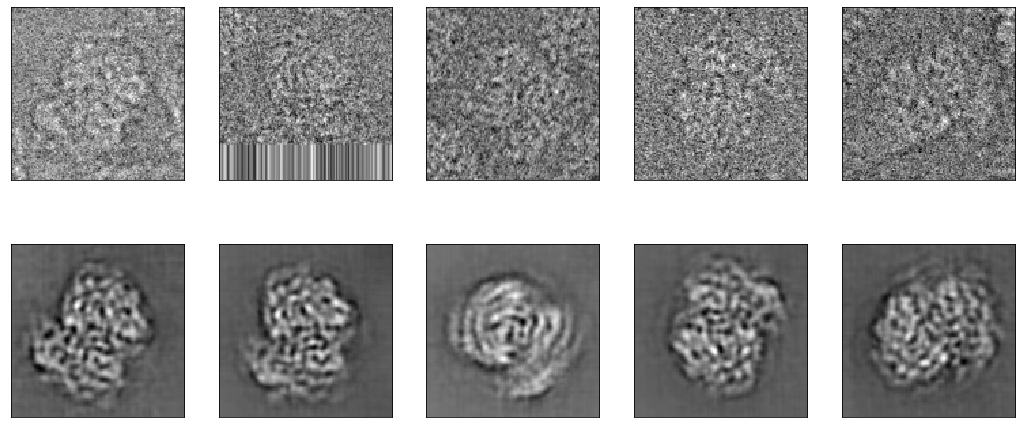

In [31]:
epoch_id = 60
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Shape of img data:
(8, 1, 128, 128)
Shape of recon:
(8, 1, 128, 128)


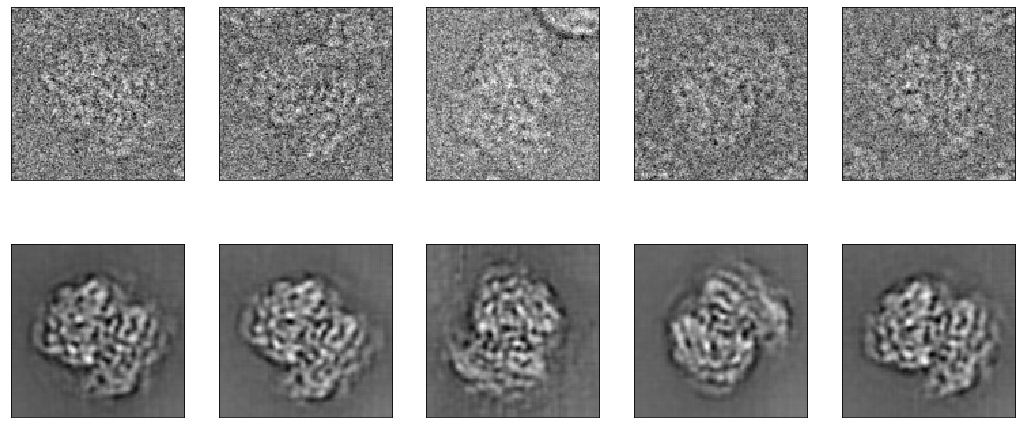

In [32]:
epoch_id = 70
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Shape of img data:
(8, 1, 128, 128)
Shape of recon:
(8, 1, 128, 128)


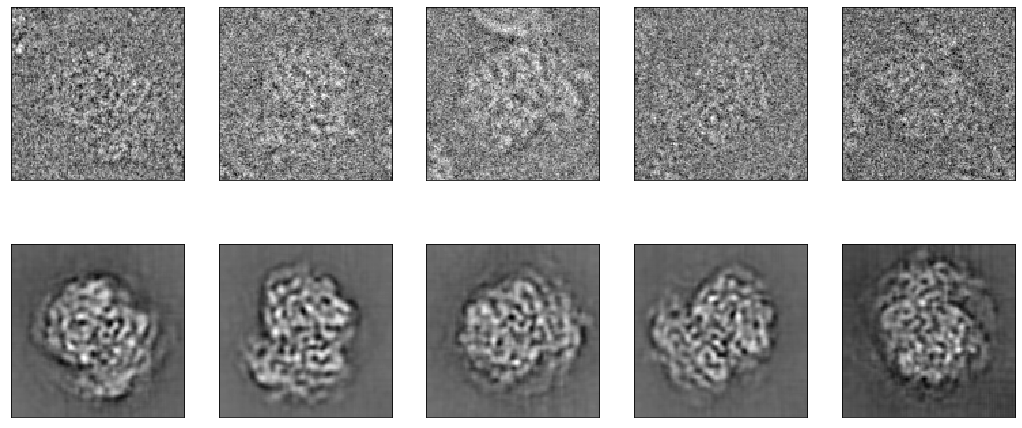

In [33]:
epoch_id = 79
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')